In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from geopy.distance import great_circle

In [3]:
dataset = pd.read_csv('/home/fm-pc-lt-173/fraud_detection/pythonProject/data/fraudTrain.csv')
print(dataset.shape)
dataset.head(5)

(1296675, 23)


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [52]:
dataset.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

**<h2>Missing Data Cleaning</h2>**

In [53]:
dataset.isnull().sum()

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [54]:
dataset.drop_duplicates(inplace=True)
dataset.count()

Unnamed: 0               1296675
trans_date_trans_time    1296675
cc_num                   1296675
merchant                 1296675
category                 1296675
amt                      1296675
first                    1296675
last                     1296675
gender                   1296675
street                   1296675
city                     1296675
state                    1296675
zip                      1296675
lat                      1296675
long                     1296675
city_pop                 1296675
job                      1296675
dob                      1296675
trans_num                1296675
unix_time                1296675
merch_lat                1296675
merch_long               1296675
is_fraud                 1296675
dtype: int64

**<h2>Feature Engineering</h2>**

In [58]:
#1. Drop Unnecessary Columns
dataset.drop(columns=['Unnamed: 0', 'street', 'last', 'first','zip','unix_time','cc_num'], inplace=True)

In [59]:
# 2. Convert to Datetime
dataset['trans_date_trans_time'] = pd.to_datetime(dataset['trans_date_trans_time'])
dataset['dob'] = pd.to_datetime(dataset['dob'])

In [60]:
# 3. Extract Date and Time Features
dataset['trans_month'] = dataset['trans_date_trans_time'].dt.month
dataset['trans_hour'] = dataset['trans_date_trans_time'].dt.hour

In [61]:
# Cyclical Encoding for Month and Hour
dataset['trans_month_sin'] = np.sin(2 * np.pi * dataset['trans_month'] / 12)
dataset['trans_month_cos'] = np.cos(2 * np.pi * dataset['trans_month'] / 12)
dataset['trans_hour_sin'] = np.sin(2 * np.pi * dataset['trans_hour'] / 24)
dataset['trans_hour_cos'] = np.cos(2 * np.pi * dataset['trans_hour'] / 24)

In [62]:
# Drop Latitude and Longitude Columns
dataset.drop(columns=['trans_month', 'trans_hour','trans_date_trans_time'], inplace=True)

In [63]:
# 4. Calculate Age from dob
dataset['age'] = (pd.to_datetime('today') - dataset['dob']).astype('<m8[Y]')
# Drop DOB column
dataset.drop(columns=['dob'], inplace=True)

In [64]:
# 5. Calculate Geospatial Distance
dataset['distance'] = dataset.apply(lambda row: great_circle((row['lat'], row['long']), (row['merch_lat'], row['merch_long'])).miles, axis=1)
# Drop Latitude and Longitude Columns
dataset.drop(columns=['lat', 'long', 'merch_lat', 'merch_long'], inplace=True)

In [65]:
# 7. Binning city population into categories
bins = [0, 10000, 50000, 100000, 500000, np.inf]
labels = ['Very Small', 'Small', 'Medium', 'Large', 'Very Large']
dataset['city_pop_category'] = pd.cut(dataset['city_pop'], bins=bins, labels=labels)
dataset.drop(columns=['city_pop'], inplace=True)

In [66]:
dataset.columns

Index(['merchant', 'category', 'amt', 'gender', 'city', 'state', 'job',
       'trans_num', 'is_fraud', 'trans_month_sin', 'trans_month_cos',
       'trans_hour_sin', 'trans_hour_cos', 'age', 'distance',
       'city_pop_category'],
      dtype='object')

In [67]:
dataset.to_csv("/home/fm-pc-lt-173/fraud_detection/pythonProject/data/final_features.csv", index=False)

**<h2>UnderSampling</h2>**

In [68]:
fraud_df = dataset.loc[dataset['is_fraud']==1]
non_fraud_df = dataset.loc[dataset['is_fraud']==0][:7506]
normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

#to do try some subsampling with some techniques

#shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)
new_df.head()


,merchant,category,amt,gender,city,state,job,trans_num,is_fraud,trans_month_sin,trans_month_cos,trans_hour_sin,trans_hour_cos,age,distance,city_pop_category
1239072,fraud_Koepp-Witting,grocery_pos,433.892845,M,Jordan Valley,OR,Economist,c48f2efccb689f2daef9ebdb03e1edec,1,1.224647e-16,-1.000000e+00,2.588190e-01,0.965926,30.0,26.856391,Very Small
600804,fraud_Bogisich-Homenick,misc_net,433.892845,M,Egan,LA,Broadcast presenter,68f2b98cba5c4ae6b7ff3f701d0cdc69,1,-1.000000e+00,-1.836970e-16,1.224647e-16,-1.000000,52.0,64.056313,Very Small
650,fraud_Koelpin and Sons,misc_net,433.892845,M,Bronx,NY,"Therapist, drama",d2f60675d5d014479f40a583988f59df,0,5.000000e-01,8.660254e-01,8.660254e-01,-0.500000,33.0,44.870702,Very Large
6933,"fraud_Becker, Harris and Harvey",personal_care,37.160000,F,Stanchfield,MN,"Lecturer, further education",01368a4501daec8b49400e0e17c5e1d6,0,5.000000e-01,8.660254e-01,-5.000000e-01,-0.866025,28.0,40.447641,Very Small
38242,fraud_Gottlieb-Hansen,personal_care,17.520000,F,Sebring,FL,Environmental consultant,5666921b2c9a994021da1bdbb9aea908,1,5.000000e-01,8.660254e-01,-2.588190e-01,0.965926,38.0,28.321900,Medium


**<h2>Correlation Analysis of the numerical features using subsampled dataset</h2>**

/tmp/ipykernel_177365/2220068973.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = dataset.corr()
/tmp/ipykernel_177365/2220068973.py:11: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sub_sample_corr = new_df.corr()


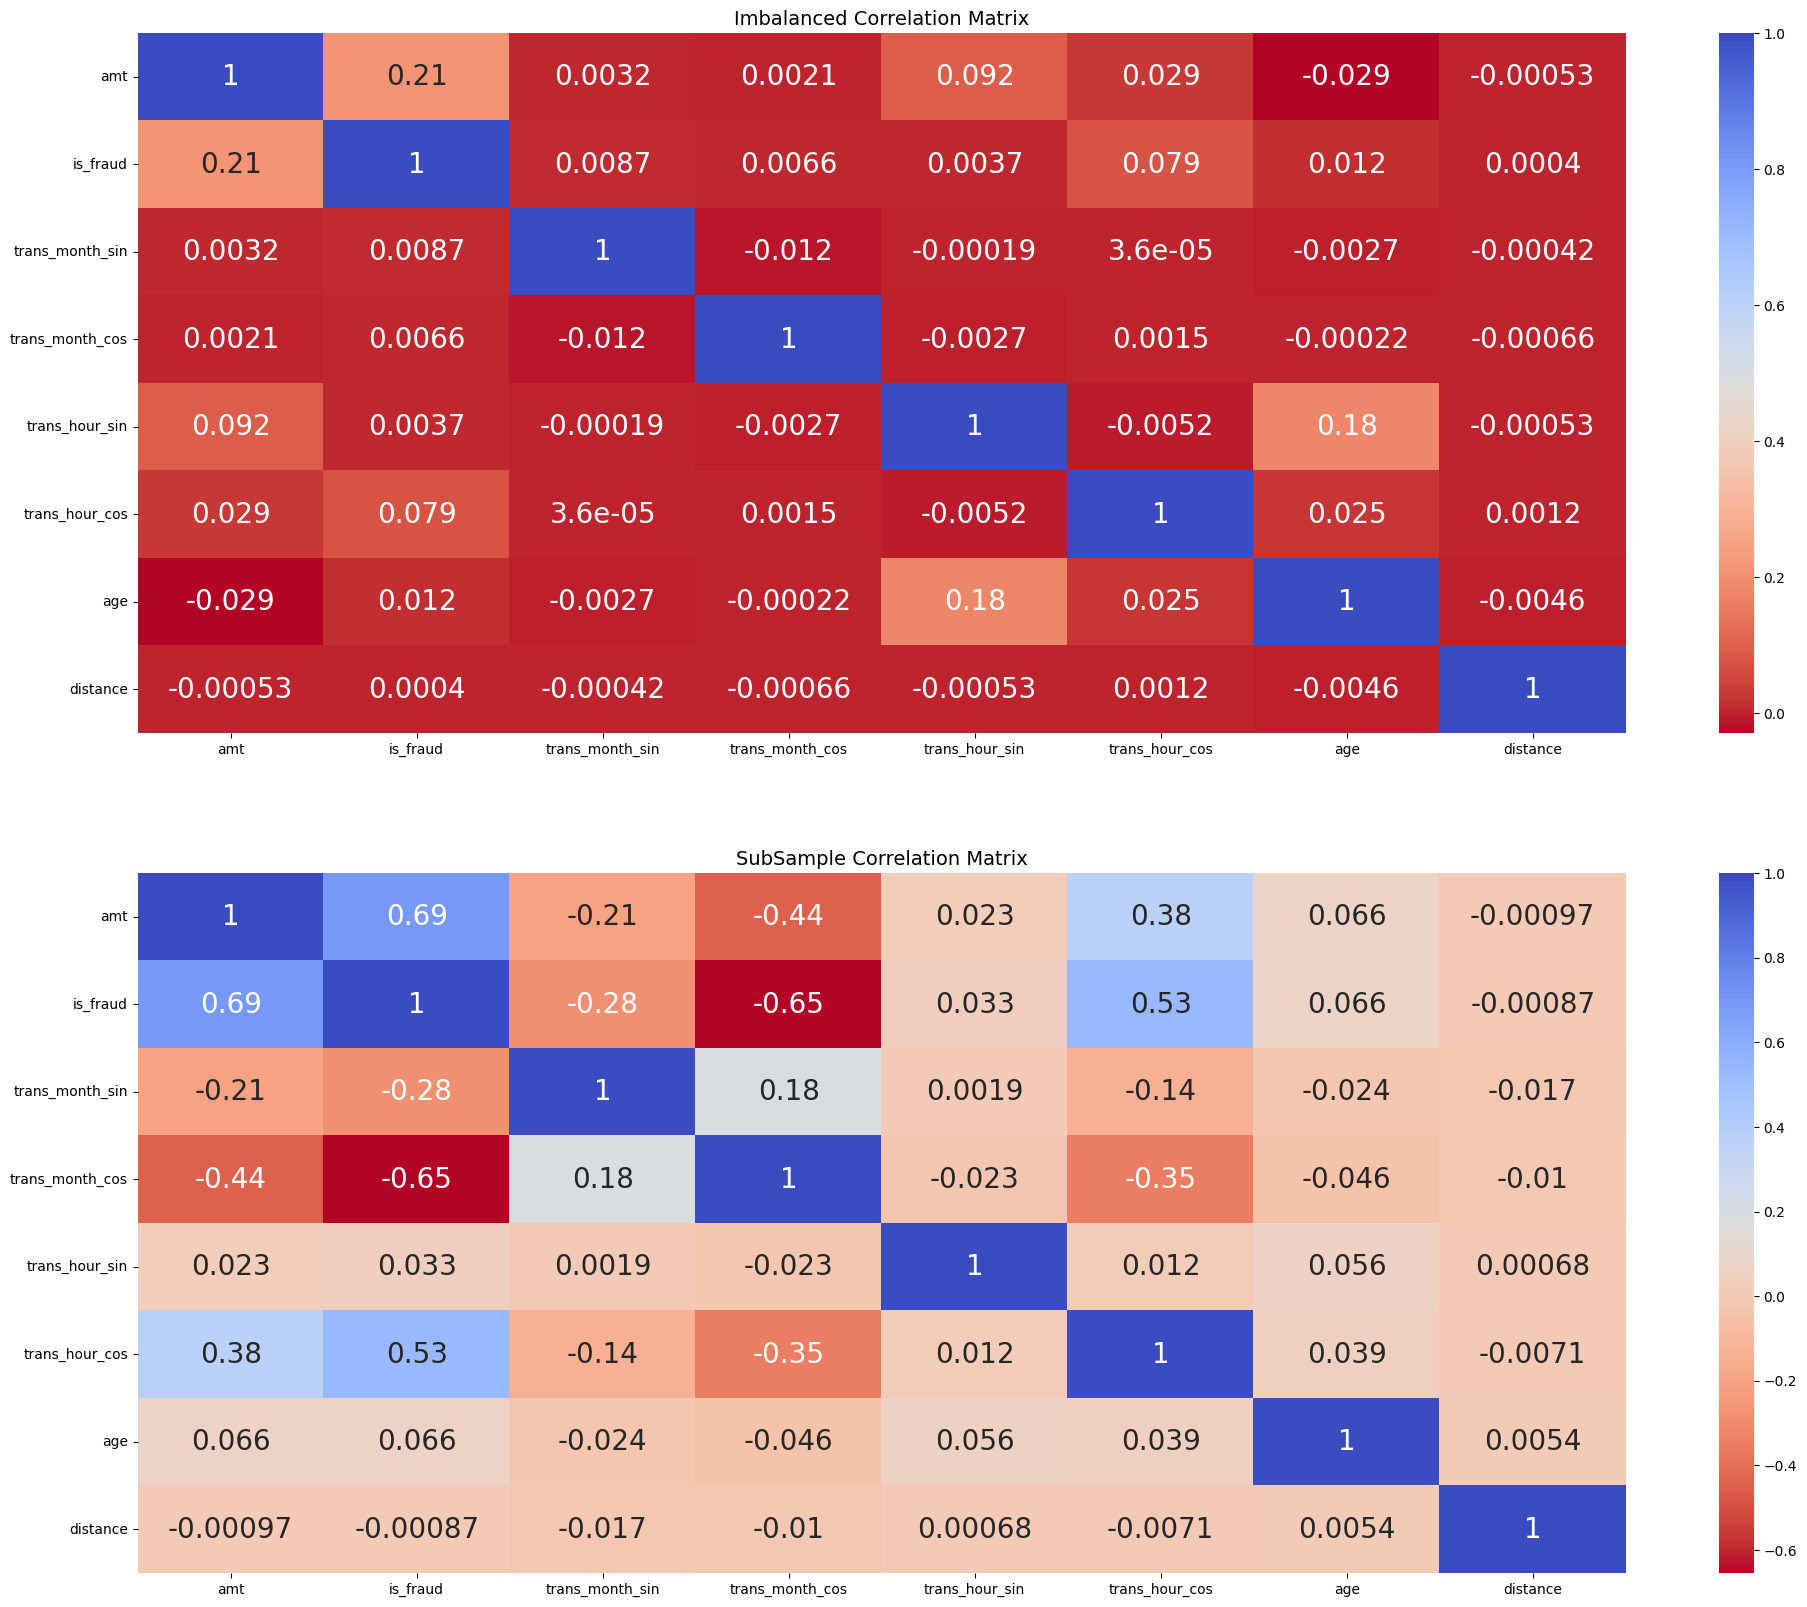

In [69]:
# Make sure we use the subsample in our correlation

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = dataset.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1, annot=True)
ax1.set_title("Imbalanced Correlation Matrix", fontsize=14)


sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2, annot=True)
ax2.set_title('SubSample Correlation Matrix', fontsize=14)
plt.show()


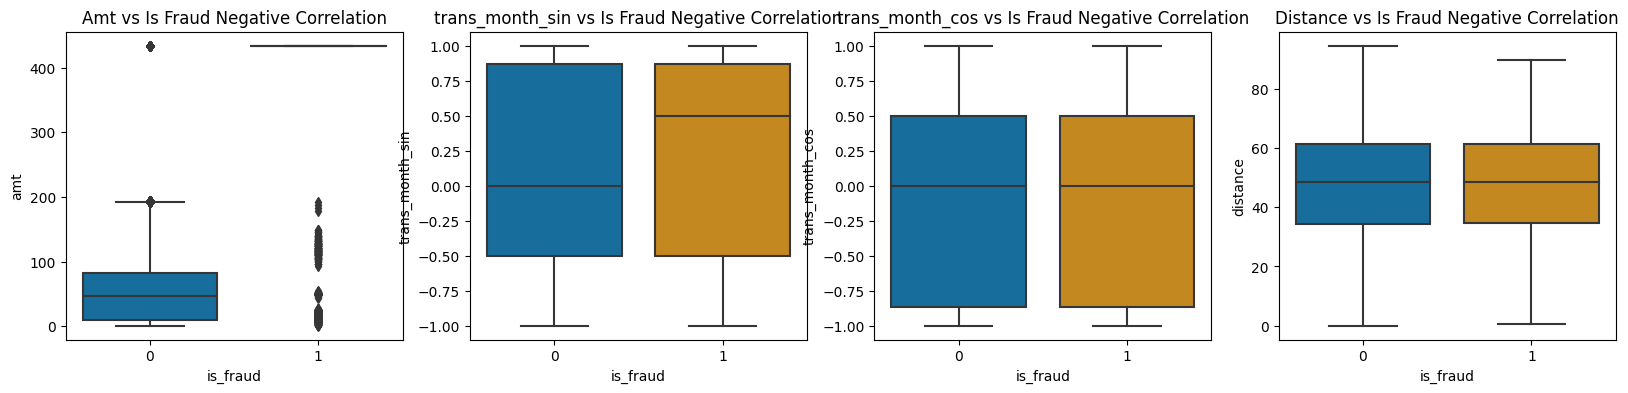

In [70]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Negative Correlations with the label (The lower the feature value the more likely it will be a fraud transaction)
sns.boxplot(x="is_fraud", y="amt", data=dataset, palette="colorblind", ax=axes[0])
axes[0].set_title('Amt vs Is Fraud Negative Correlation')

sns.boxplot(x="is_fraud", y="trans_month_sin", data=dataset, palette="colorblind", ax=axes[1])
axes[1].set_title('trans_month_sin vs Is Fraud Negative Correlation')


sns.boxplot(x="is_fraud", y="trans_month_cos", data=dataset, palette="colorblind", ax=axes[2])
axes[2].set_title('trans_month_cos vs Is Fraud Negative Correlation')


sns.boxplot(x="is_fraud", y="distance", data=dataset, palette="colorblind", ax=axes[3])
axes[3].set_title('Distance vs Is Fraud Negative Correlation')

plt.show()


<h2>Outlier Detection</h2>

In [55]:
def iqrrange(df):
  quantile1, quantile3 = np.percentile(df,[25,75])
  iqr_value = quantile3 - quantile1
  lower_bound = quantile1 - 1.5 * iqr_value
  upper_bound = quantile3 + 1.5 * iqr_value
  return lower_bound, upper_bound

In [56]:
lower, higher = iqrrange(dataset['amt'])
print(lower, higher)
dataset.loc[(dataset['amt'] < lower) | (dataset['amt'] > higher),"amt"] = dataset.loc[(dataset['amt'] < lower) | (dataset['amt'] > higher),"amt"].mean()

-100.58499999999998 193.375
